## Simulation-Based Inference SIR Model: Training
Created: May 23, 2022 Prosper and Prosper<br>
Updated: Apr 05, 2023 HBP

### Introduction 

The purpose of this notebook is to approximate $\mathbb{P}(\lambda \le \lambda_0 | \theta) = \mathbb{E}(Z | \theta)$ in two different ways: 1) using a 2D histogram and 2) a neural network, where for a given hypothesis $H_0: \theta = \theta_0$ versus $H_1: \theta \ne \theta_0$, $\lambda_0$ is the observed value of the test statistic $\lambda$ (see SIR_generate_data.ipynb for details.)

Our test statistic $\lambda$  is large for parameters $\theta$ *disfavored* by the data, whereas in the algorithm listed below[1], a modified version of we introduce, $\lambda$ is small for disfavored parameters. Therefore, we're approximating the cumulative distribution function (cdf) rather than the p-value. 

In the algorithm below the stochastic forward simulator $F_\theta$ is the CTMC simulator given in notebook SIR_generate_data.ipynb, which simulates the ensemble of synthetic epidemics.

![pvalue](pvalue.png)


### Approximating $\mathbb{P}(\lambda \le \lambda_0 | \theta) = \mathbb{E}(Z | \theta)$ by histogramming

The quantity $\mathbb{E}(Z | \theta)$ can be approximated using the following algorithm, which therefore provides a way to check the quality of the deep neural network model.

$\theta = \alpha, \beta$

  1. Create histogram $h_w \gets \text{histogram}(\alpha, \beta, \text{weight}=Z)$
  1. Create histogram $h_u \gets \text{histogram}(\alpha, \beta, \text{weight}=1)$
  1. Approximate $\mathbb{P}(\lambda \le \lambda_0 | \alpha, \beta)$ by $h_w \, / \, h_u$

### References
  1. Anne Lee *et al.*, https://arxiv.org/abs/2107.03920

In [7]:
import os, sys

sys.path.append('../')

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# module to save results
#import joblib as jb

# pytorch
import torch
import torch.nn as nn

# split data into a training set and a test set
from sklearn.model_selection import train_test_split

# to reload modules
import importlib

import SIR_dnn_util as ut
from SIR_gen_util import Fsolve, test_statistic, SIRdata

%matplotlib inline

In [4]:
# update fonts
FONTSIZE = 18
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

### Define model $f(\alpha, \beta, \lambda; \omega)$

For simple models, it is sufficient to use the __Sequential__ class.

In [5]:
%%writefile ../models/SIR_dnn_cdf_800K.py

name     = 'SIR_dnn_cdf_800K'
features = ['lo', 'alpha', 'beta']
target   = 'Zo'
nodes    = 25

import torch
import torch.nn as nn

model = nn.Sequential(nn.Linear( len(features), nodes),
                      nn.ReLU(),
                      
                      nn.Linear(nodes, nodes),
                      nn.ReLU(),
                      
                      nn.Linear(nodes, nodes),
                      nn.ReLU(), 
                      
                      nn.Linear(nodes, nodes),
                      nn.ReLU(),                    
                      
                      nn.Linear(nodes, nodes),
                      nn.ReLU(), 
                      
                      nn.Linear(nodes, nodes),
                      nn.ReLU(),                    
                      
                      nn.Linear(nodes, 1), 
                      nn.Sigmoid()) 

Writing ../models/SIR_dnn_cdf_800K.py


In [8]:
import models.SIR_dnn_cdf_800K as NN
importlib.reload(NN)
name     = NN.name
model    = NN.model
features = NN.features
target   = NN.target
modelfile  = '%s.dict' % NN.name
print(name)
print(model)
print('number of parameters: %d' % ut.number_of_parameters(model))

SIR_dnn_cdf_800K
Sequential(
  (0): Linear(in_features=3, out_features=25, bias=True)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): ReLU()
  (4): Linear(in_features=25, out_features=25, bias=True)
  (5): ReLU()
  (6): Linear(in_features=25, out_features=25, bias=True)
  (7): ReLU()
  (8): Linear(in_features=25, out_features=25, bias=True)
  (9): ReLU()
  (10): Linear(in_features=25, out_features=25, bias=True)
  (11): ReLU()
  (12): Linear(in_features=25, out_features=1, bias=True)
  (13): Sigmoid()
)
number of parameters: 3376


### Load data

__Note__: The $\alpha$ and $\beta$ parameters have been scaled so that they are of $\cal{O}(1)$. Therefore, no further transformation is needed.

In [9]:
print('SIRdata')
data = SIRdata
data.alpha_min,  data.alpha_max = 0.10, 0.90
data.beta_min,   data.beta_max  = 0.25, 0.65
print(data)
print()

datafile = '../data/SIR_traindata_800k.csv'

print('loading %s' % datafile)
df = pd.read_csv(datafile)
print('number of rows:', len(df))

df[:5]

SIRdata
 D           : [  3  25  75 227 296 258 236 192 126  71  28  11   7]
 I0          : 3
 O           : [  3  25  75 227 296 258 236 192 126  71  28  11   7]
 R0          : 0
 S0          : 763
 T           : [ 0  2  3  4  5  6  7  8  9 10 11 12 13]
 alpha0      : 0.465
 alpha_bins  : 16
 alpha_max   : 0.9
 alpha_min   : 0.1
 alpha_scale : 1.0
 beta0       : 0.00237
 beta_bins   : 16
 beta_max    : 0.65
 beta_min    : 0.25
 beta_scale  : 0.005
 model       : SIR
 scale       : 50
 tmax        : 14.0
 tmin        : 0.0


loading ../data/SIR_traindata_800k.csv
number of rows: 800000


,Unnamed: 0,alpha,beta,xi,li,l0,lo,Z0,Zo
0,0,0.303317,0.422783,"[3, 16, 52, 110, 245, 348, 368, 310, 240, 179,...",4.379502,5.116309,0.238410,1,1
1,1,0.896044,0.309270,"[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",4.018788,41.881590,1.836105,1,1
2,2,0.210181,0.561672,"[3, 28, 159, 418, 480, 457, 375, 297, 244, 203...",4.526100,8.810860,0.084874,1,0
3,3,0.559625,0.306321,"[3, 9, 13, 16, 18, 26, 45, 76, 99, 112, 108, 1...",3.515383,16.400865,0.129759,1,1
4,4,0.407705,0.620262,"[3, 118, 312, 388, 316, 219, 148, 105, 68, 48,...",0.526044,6.548893,0.126752,1,1


In [10]:
def plot_data(d, filename='../images/fig_SIR_flu_data.pdf', fgsize=(5, 4), ftsize=14):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)
    
    # pad
    #plt.subplots_adjust(hspace=0.01)
    #plt.subplots_adjust(wspace=0.3)

    #
    xmin, xmax = 0,  18
    ymin, ymax = 0, 400

    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r'$t$ (day)', fontsize=ftsize)
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(r'infected (count)', fontsize=ftsize)
    
    ax.scatter(d.T, d.D, s=20, c='black', 
               label=r'number of individuals in class $I$')
    ax.legend(fontsize=14)
               
    ax.grid() 
    
    plt.tight_layout()
    plt.savefig(filename)
    print(filename)

../images/fig_SIR_flu_data.pdf


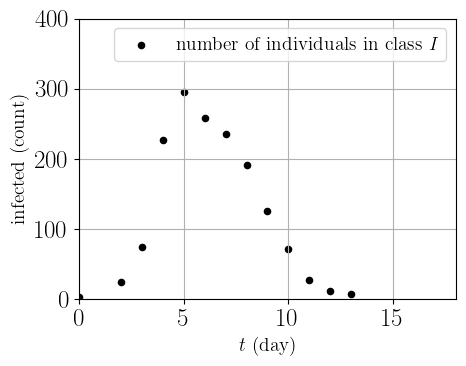

In [11]:
plot_data(SIRdata)

### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

The validation set will be some small fraction of the training set and can be used, for example, to decide when to stop the training.

train set size:        750000
validation set size:     5000
test set size:          45000
    0
saved to file: fig_hist_SIR_dnn_cdf_800K.png


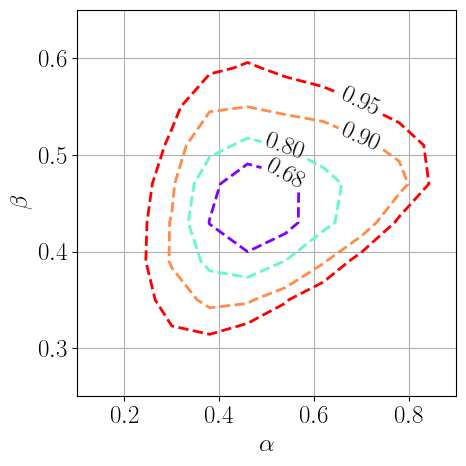

In [12]:
# Fraction of the data assigned as test data and validation
tfraction = 45/800
vfraction =  5/755
tdata     = df

SIRdata.alpha_bins = 10
SIRdata.beta_bins  = 10

# Split data into a part for training and a part for testing
train_data, valid_data, test_data = ut.split_data(df, 
                                         test_fraction=tfraction, 
                                         validation_fraction=vfraction) 

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

def smooth_hist(tfraction=250/275, K=1, d=SIRdata):
    P = np.zeros((data.alpha_bins, d.beta_bins))
    for k in range(K):
        print('\r%5d' % k, end='')
        _, test   = train_test_split(df, 
                                 test_size=tfraction, 
                                 shuffle=True)
        p, xe, ye = ut.hist_data(test, SIRdata)
        P += p
    print()
    P /= K
    return P, xe, ye

hist = smooth_hist()

ut.plot_model(tdata, SIRdata, 
              filename='fig_hist_%s.png' % NN.name)

### Empirical risk (that is, average loss)

The empirical risk, which is the __objective function__ we shall minimize, is defined by

\begin{align}
R_M(\theta) & = \frac{1}{M} \sum_{m=1}^{M} L(t_m, f_m),
\end{align}

where 

\begin{align*}
    f_m & \equiv f(\mathbf{x}_m, \theta).
\end{align*}

The empirical risk $R_M$ approximates the __risk functional__

\begin{align}
R[f] & = \int \cdots \int \, p(t, \mathbf{x}) \, L(t, f(\mathbf{x}, \theta)) \, dt \, d\mathbf{x} .
\end{align}

The quantity $p(t, \mathbf{x}) \, dt\, d\mathbf{x}$ is the probability distribution from which the sample $\{ (t_m, \mathbf{x}_m), m = 1,\cdots, M \}$ is presumed to have been drawn. 

We use the __quadratic loss__

\begin{align}
    L(t, f) &= (t - f)^2 .
\end{align}

### Train!

In [13]:
traces = ([], [], [])
traces_step = 10

In [ ]:
n_batch       = 50
n_iterations  = 5000000
early_stopping= 50000
learning_rate = 1.e-3

optimizer     = torch.optim.Adam(model.parameters(), 
                                 lr=learning_rate) 

traces = ut.train(model, optimizer, 
                  modelfile, early_stopping,
                  ut.average_quadratic_loss,
                  ut.get_batch, 
                  train_data, valid_data,
                  features, target,
                  n_batch, 
                  n_iterations,
                  traces,
                  step=traces_step)

n_batch       = 500
n_iterations  = 5000000
early_stopping= 50000
learning_rate = 1.e-4

traces = ut.train(model, optimizer, 
                  modelfile, early_stopping,
                  ut.average_quadratic_loss,
                  ut.get_batch, 
                  train_data, valid_data,
                  features, target,
                  n_batch, 
                  n_iterations,
                  traces,
                  step=traces_step)

ut.plot_average_loss(traces)

Iteration vs average loss
iteration train-set valid-set
        0 0.2409548 0.2409542
       10 0.2217185 0.2217102
       20 0.2016223 0.2016122
       30 0.1758272 0.1758637
       40 0.1349301 0.1351146
   174590 0.0344212 0.0353170    174590:    151280/0.03482759/    23310

### Plot results of trained model

In [7]:
import SIR_gen_util as gt
importlib.reload(gt)

def dnn(x, y, d, f=model):
    l = np.array(gt.test_statistic(x, y, d))
    I = np.array([l, x, y]).T
    X = torch.Tensor(I)
    
    # go to evaluation mode
    model.eval()
    
    # compute,reshape to a 1d array, and convert to a numpy array
    Y = model(X).view(-1,).detach().numpy()
    if len(Y) == 1:
        return Y[0]
    else:
        return Y

In [8]:
Load_model = True
print('load model: %s' % modelfile)

if Load_model:
    modeldict = torch.load(modelfile)
    NN.model.load_state_dict(modeldict)

load model: SIR_dnn_cdf_800K.dict


device: cpu
alpha:      0.468, beta:      0.445*5.0e-03, min(fun):      0.457
                   beta:      0.00223
saved to file: fig_SIR_dnn_cdf_800K.pdf


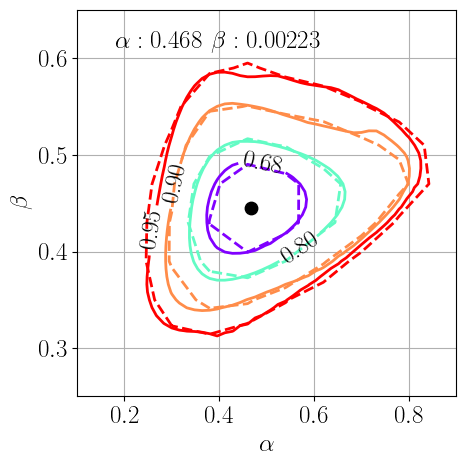

In [10]:
import SIR_dnn_util as ut
importlib.reload(ut)

SIRdata.O = SIRdata.D
res = ut.best_fit(ut.nll, dnn, SIRdata)

ut.plot_model(test_data, SIRdata, dnn, res, hist=hist,
              filename='fig_%s.pdf' % NN.name)

In [14]:
def cdf(x, y, z):
    X = np.array([x, y, z]).T
    inputs = torch.Tensor(X)
    # go to evaluation mode
    model.eval()
    
    # compute,reshape to a 1d array, and convert to a numpy array
    Y = model(inputs).view(-1,).detach().numpy()
    if len(Y) == 1:
        return Y[0]
    else:
        return Y

In [15]:
select = cdf(test_data.alpha, test_data.beta, test_data.l0) <= 0.95
CL95   = test_data[['alpha', 'beta', 'I']][select]
CL95.to_csv('SIR_CL95.csv', index=False)
len(CL95)

4386